# Trabalho Final de Álgebra Linear Numérica

Brisa do Nascimento Barbosa e Mateus Krause Eleotério

O presente trabalho visa aplicar um método de interpolação de pontos, obtidos automaticamente por meio de visão computacional, para extrair o contorno de uma folha. Essa abordagem é fundamental para diversas aplicações, como a análise da canópia, que se refere à cobertura formada pelas copas das plantas em uma determinada área, influenciando diretamente a interceptação da luz, a troca de gases e os processos ecológicos associados.

A reconstrução 3D da canópia vegetal é um campo essencial para a modelagem funcional-estrutural de plantas (Functional-Structural Plant Modeling - FSPM), permitindo simular a distribuição e análise da luz dentro das copas das plantas. A reconstrução superficial de plantas contribui para a compreensão detalhada da arquitetura vegetal, o que é crucial para estudos de ecologia, fisiologia e melhoramento vegetal.

O artigo que mais inspirou este trabalho foi *"A Leaf Modeling and Multi-scale Remeshing Method for Visual Computation via Hierarchical Parametric Vein and Margin Representation"*, que emprega conceitos complexos para a modelagem de folhas. Nosso objetivo é iniciar com um método mais simples, baseado em splines, com potencial de expansão para futuras pesquisas, incluindo a identificação automática do sistema vascular das folhas, análise ecológica considerando parâmetros como luz, interação funcional com insetos, e características fisiológicas.

Com essa abordagem inicial de modelagem por splines, podemos gerar representações precisas do contorno foliar, que servem como base para análises mais avançadas, além de facilitar a integração com técnicas de visão computacional e modelagem funcional para o estudo aprofundado da dinâmica das plantas.


### Importação de bibliotecas

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D

# Modelo 2D

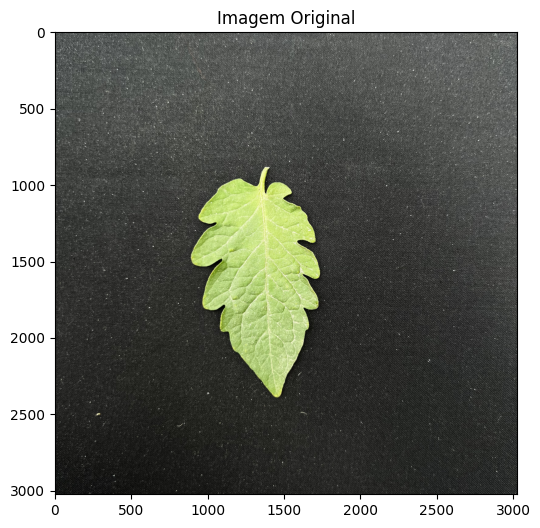

In [51]:
url = "https://raw.githubusercontent.com/mateuskrause/tp-aln/main/DATASET/exemplar_05.JPG"
resp = requests.get(url)
img = np.array(Image.open(BytesIO(resp.content)).convert("RGB"))

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("Imagem Original")
plt.show()

A imagem original está no formato **RGB** (Red, Green, Blue), que é ótimo para exibição em telas, mas nem sempre é o mais eficiente para segmentação.

Para segmentar **cores específicas** (como o verde da folha), utilizamos o modelo de cores **HSV**:

- **H (Hue / Matiz)**: Representa a **cor** propriamente dita (0 a 180 no OpenCV).
- **S (Saturation / Saturação)**: Representa o quão "viva" é a cor. Cores mais acinzentadas têm saturação baixa.
- **V (Value / Valor)**: Representa o brilho da cor.

O espaço HSV facilita muito a criação de **máscaras baseadas em cor**, pois conseguimos isolar apenas o tom de verde, independentemente da iluminação. Daí, podemos segmentar a cor da folha utilizando intervalos de valores de matiz (Hue), saturação e brilho.

Queremos isolar **tons de verde**, então definimos um intervalo de valores que representam o verde comum:

- Hue: entre 40 e 100 (aproximadamente verde amarelado até verde azulado)
- Saturação e Valor: usamos limites abertos para incluir tons claros e escuros

Usamos `cv2.inRange()` para criar máscara binária (1 onde está verde).  

Depois, aplicamos **operações morfológicas** para limpar ruídos:

- `morphologyEx(..., MORPH_CLOSE)` preenche pequenos buracos na máscara.

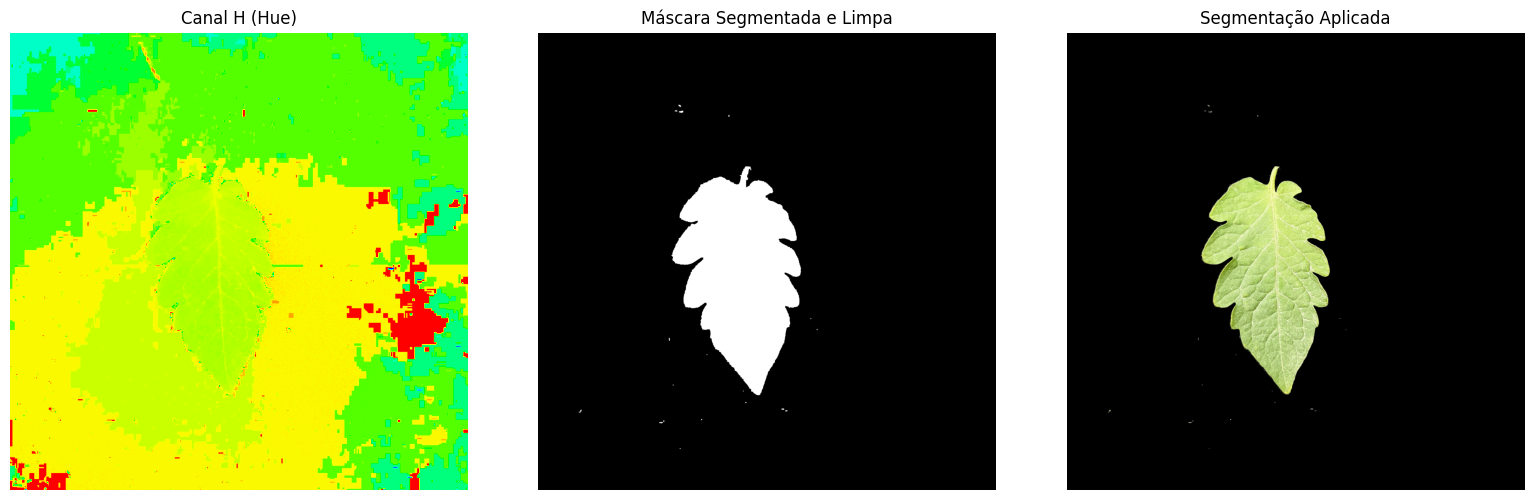

In [52]:
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

lower_green = np.array([30, 40, 40])
upper_green = np.array([90, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

kernel = np.ones((5, 5), np.uint8)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel, iterations=1)

# Aplicar máscara na imagem original
masked_img = cv2.bitwise_and(img, img, mask=mask_clean)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

axs[0].imshow(hsv[:, :, 0], cmap='hsv')
axs[0].set_title("Canal H (Hue)")
axs[1].imshow(mask_clean, cmap='gray')
axs[1].set_title("Máscara Segmentada e Limpa")
axs[2].imshow(masked_img)
axs[2].set_title("Segmentação Aplicada")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

Identificamos o maior contorno da imagem segmentada, que será usado para análise de curvatura. Também garantimos que o contorno seja fechado.

In [53]:
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour = max(contours, key=cv2.contourArea).squeeze()
contour_closed = np.vstack([contour, contour[0]])

Usamos derivadas suavizadas com filtro Gaussiano para calcular a curvatura ao longo do contorno. Isso reduz o ruído e facilita a detecção de pontos significativos.

In [55]:
def smooth_derivative(signal, sigma=3.0):
    smoothed = gaussian_filter1d(signal, sigma, axis=0)
    grad = np.gradient(smoothed, axis=0)
    return grad

dx = smooth_derivative(contour_closed[:, 0].astype(float))
dy = smooth_derivative(contour_closed[:, 1].astype(float))
d2x = smooth_derivative(dx)
d2y = smooth_derivative(dy)

curvature = (dx * d2y - dy * d2x) / ((dx**2 + dy**2)**1.5 + 1e-10)
abs_curvature = np.abs(curvature)


Segmentamos o contorno em `num_points` segmentos iguais iguais e, em cada segmento, escolhemos o ponto de maior curvatura local. Isso garante pontos bem distribuídos e relevantes para a forma da borda. Isso garante uma distribuição uniforme e que cada ponto escolhido seja relevante do ponto de vista morfológico.

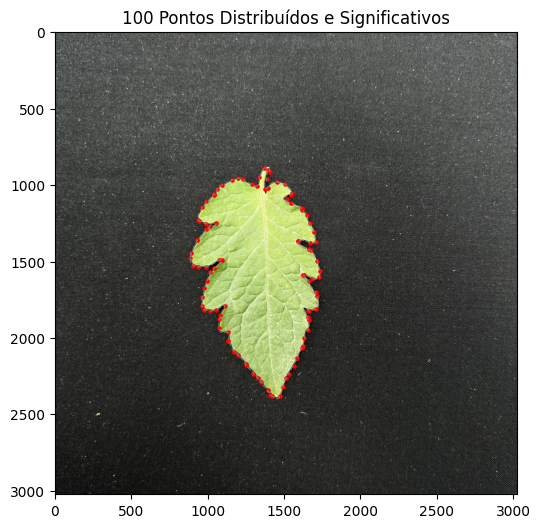

In [63]:
def significant_points(img, contour_closed, abs_curvature, num_points=100):
    N = len(contour_closed)
    step = N // num_points

    final_indices = []
    for i in range(num_points):
        start = i * step
        end = (i + 1) * step if i < num_points - 1 else N
        region_indices = range(start, end)
        best_idx = max(region_indices, key=lambda idx: abs_curvature[idx])
        final_indices.append(best_idx)

    final_points = contour_closed[final_indices]

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.plot(contour_closed[:, 0], contour_closed[:, 1], '--', color='gray', lw=1, alpha=0.8)
    plt.scatter(final_points[:, 0], final_points[:, 1], c='red', s=5, marker='o')
    plt.title(f'{num_points} Pontos Distribuídos e Significativos')
    plt.show()

significant_points(img, contour_closed, abs_curvature, num_points=100)

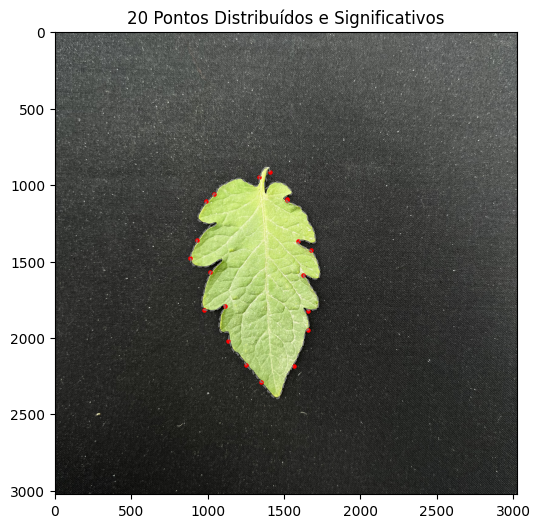

In [64]:
significant_points(img, contour_closed, abs_curvature, num_points=20)

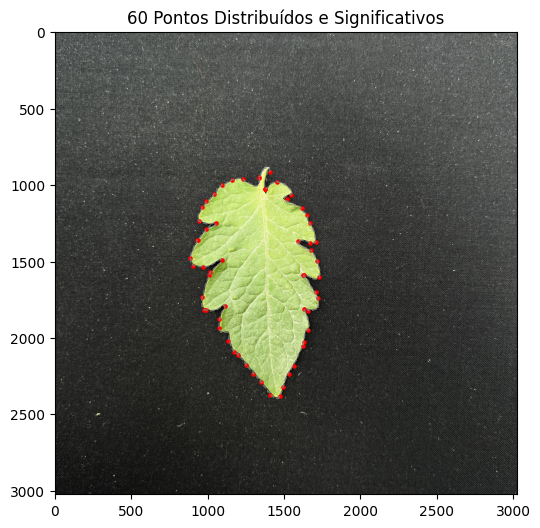

In [65]:
significant_points(img, contour_closed, abs_curvature, num_points=60)

## Interpolação com Splines
Depois de pegar os pontos principais da borda, o próximo passo é reconstruir uma curva suave que passe por eles. Para isso, usamos splines periódicas, que funcionam bem para contornos fechados como o da folha.

**Splines** são funções polinomiais por partes que oferecem várias vantagens para interpolação
- Garantem continuidade até a segunda derivada (C²)
- Adaptam-se a formas complexas sem oscilações indesejadas
-  Mudanças em um ponto afetam apenas regiões próximas

Para contornos **fechados** (como bordas de folhas), splines periódicas são essenciais porque:
- **Continuidade na junção**: Garantem que o início e fim da curva se conectem suavemente
- **Derivadas consistentes**: As derivadas também são contínuas na junção
- **Preservação da forma**: Evitam distorções artificiais próximas ao ponto de fechamento

# Modelo 3D 

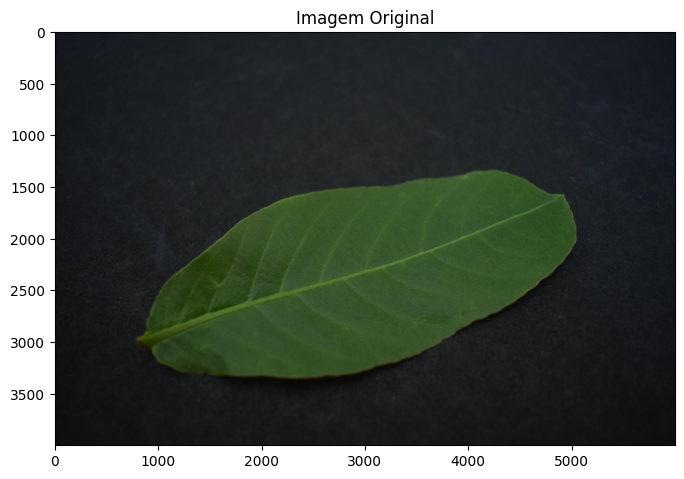

In [42]:
# Download e visualização da imagem
url = "https://raw.githubusercontent.com/mateuskrause/tp-aln/main/DATASET/exemplar_01.JPG"
response = requests.get(url)
img = np.array(Image.open(BytesIO(response.content)))

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title("Imagem Original")
plt.show()

Convertendo a imagem para o espaço de cor HSV e segmentando regiões verdes, como anteriormente.

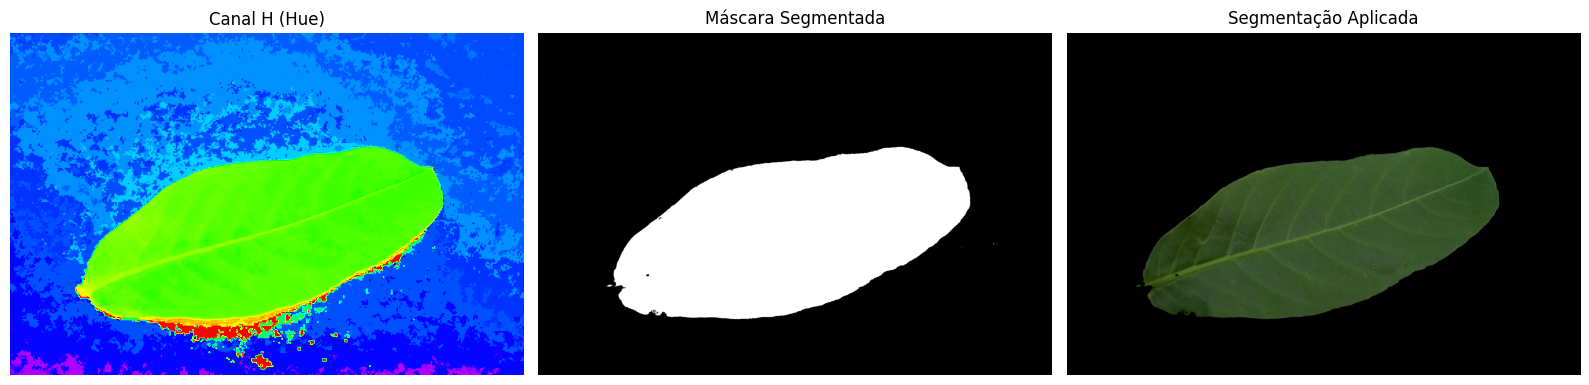

In [32]:
# HSV e máscara
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
lower_green = np.array([40, 50, 50])
upper_green = np.array([100, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

# Limpeza da máscara
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Aplicar máscara
masked_img = cv2.bitwise_and(img, img, mask=mask_cleaned)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(hsv[:, :, 0], cmap='hsv')
axs[0].set_title("Canal H (Hue)")
axs[1].imshow(mask_cleaned, cmap='gray')
axs[1].set_title("Máscara Segmentada")
axs[2].imshow(masked_img)
axs[2].set_title("Segmentação Aplicada")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

Aplicamos o MiDaS (**M**ulti-**D**epth **A**ware **S**ynthesis), que é um modelo de aprendizado profundo desenvolvido para estimar mapas de profundidade monoculares — isto é, profundidade relativa da cena apenas a partir de uma imagem 2D. Ele gera uma imagem em escala de cinza, onde cada pixel indica a profundidade relativa (quanto menor, mais perto).


Using cache found in C:\Users\nbbri/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\nbbri/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\nbbri/.cache\torch\hub\intel-isl_MiDaS_master


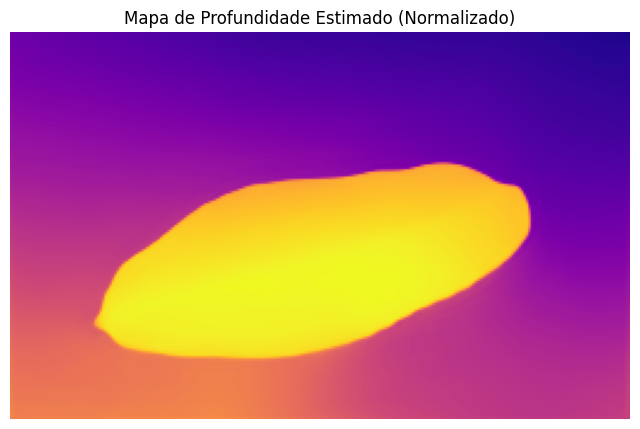

In [43]:
import torch

# Carregar modelo MiDaS e transformações
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
transforms = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform

# Configurar dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device).eval()

# Transformar e enviar imagem para dispositivo
inp = transforms(img).to(device)

with torch.no_grad():
    pred = midas(inp)

# Extrair profundidade e normalizar
depth = pred.squeeze().cpu().numpy()
dmin, dmax = depth.min(), depth.max()
depth_n = (depth - dmin) / (dmax - dmin)

# Visualizar mapa de profundidade normalizado
plt.figure(figsize=(8,8))
plt.imshow(depth_n, cmap='plasma')
plt.title("Mapa de Profundidade Estimado (Normalizado)")
plt.axis('off')
plt.show()


O mapa de profundidade gerado por modelos como o MiDaS tem resolução diferente da imagem original, geralmente menor. Para aplicar a segmentação corretamente também na profundidade, precisamos redimensionar a máscara da folha para o mesmo tamanho do mapa de profundidade.

In [44]:
h, w = depth_n.shape
mask_down = cv2.resize(mask_cleaned.astype(np.uint8), (w,h), interpolation=cv2.INTER_NEAREST)

# Normalizar máscara para valores entre 0 e 1
mask_f = mask_down.astype(np.float32) / 255.0
# Aplicar máscara no mapa de profundidade
depth_leaf = depth_n * mask_f

Para identificar bordas precisas da folha na profundidade, extraímos um "anel" na borda da máscara:

- Erode a máscara para reduzir sua área.
- Subtrai a máscara erodida da original para obter um anel nas bordas.

Caso existam vários anéis, mantemos apenas o maior, que corresponde à borda principal da folha.

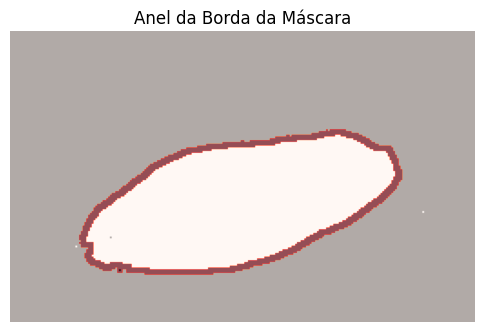

In [47]:
# Erosão para criar anel
eroded = cv2.erode(mask_down, np.ones((7,7), np.uint8))

# Anel = máscara original menos erodida
rim = ((mask_down - eroded) > 0).astype(np.uint8)

# Encontrar contornos do anel
contours, _ = cv2.findContours(rim, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) > 0:
    # Maior contorno
    largest_contour = max(contours, key=cv2.contourArea)
    rim_largest = np.zeros_like(rim)
    cv2.drawContours(rim_largest, [largest_contour], -1, 1, thickness=cv2.FILLED)

    eroded_largest = cv2.erode(rim_largest, np.ones((7,7), np.uint8))
    rim = ((rim_largest - eroded_largest) > 0).astype(np.uint8)

plt.figure(figsize=(6,6))
plt.imshow(mask_down, cmap='gray')
plt.imshow(rim, cmap='Reds', alpha=0.7)
plt.title("Anel da Borda da Máscara")
plt.axis('off')
plt.show()


Para identificar detalhes importantes na forma e na superfície da folha, aplicamos o detector de bordas Canny, tanto na imagem 2D quanto no mapa de profundidade.

No mapa de profundidade, o objetivo é realçar mudanças bruscas de relevo, como nervuras e dobras. Já na máscara da folha, buscamos realçar o contorno geométrico da folha.

Usamos dois pares de limiares diferentes para ajustar a sensibilidade:
- Na máscara 2D: limiares mais altos (100–200), pois a imagem é limpa
- No mapa de profundidade: limiares mais baixos (50–150), para captar variações suaves

Após detectar as bordas, aplicamos a máscara do anel da borda para filtrar apenas as bordas próximas ao contorno da folha. 

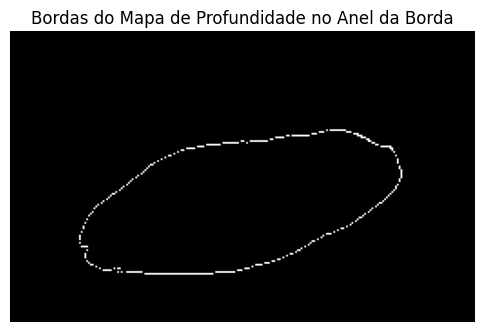

In [48]:
# Detector Canny na máscara downsized para bordas
edges_mask = cv2.Canny(mask_down, 100, 200)

# Detector Canny no mapa de profundidade para bordas
depth_uint8 = np.uint8(depth_leaf * 255)
edges_depth = cv2.Canny(depth_uint8, 50, 150)

# Filtrar bordas para a região do anel
edges_ring = cv2.bitwise_and(edges_depth, edges_depth, mask=rim.astype(np.uint8))

# Plot
plt.figure(figsize=(6,6))
plt.imshow(edges_ring, cmap='gray')
plt.title("Bordas do Mapa de Profundidade no Anel da Borda")
plt.axis('off')
plt.show()


Calculamos o gradiente da profundidade na região do anel para detectar onde há mudanças significativas. Ooperador de Sobel, que estima a variação da profundidade nas direções horizontal (grad_x) e vertical (grad_y). A partir desses dois componentes, obtemos a magnitude do gradiente, que representa a intensidade da mudança de relevo em cada ponto da folha.

Enquanto **Canny** detecta bordas bem definidas, **gradientes** capturam:
- **Mudanças gradativas**: Transições suaves mas significativas
- **Intensidade quantitativa**: Não apenas presença, mas magnitude da mudança
- **Sensibilidade ajustável**: Limiar pode ser otimizado para cada aplicação

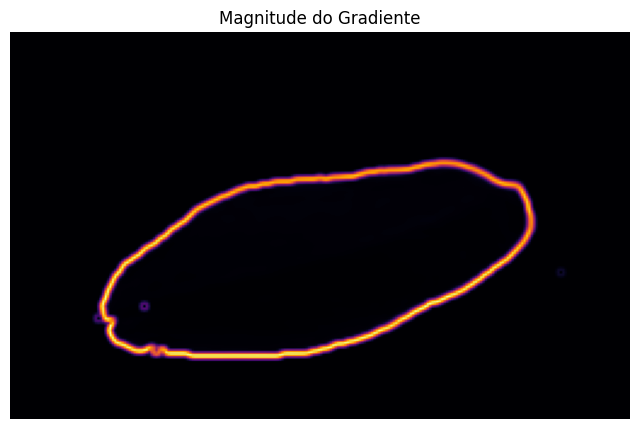

In [50]:
grad_x = cv2.Sobel(depth_leaf, cv2.CV_64F, 1, 0, ksize=5)
grad_y = cv2.Sobel(depth_leaf, cv2.CV_64F, 0, 1, ksize=5)
grad_mag = np.sqrt(grad_x**2 + grad_y**2)

th = 0.04
dges = ((grad_mag > th) & (rim > 0))

# Visualização
plt.figure(figsize=(8, 6))
plt.imshow(grad_mag, cmap='inferno')
plt.title("Magnitude do Gradiente")
plt.axis('off')
plt.show()


Assim, rendedizando a superfície 3D da folha com a borda detectada sobreposta, temos algo impreciso.


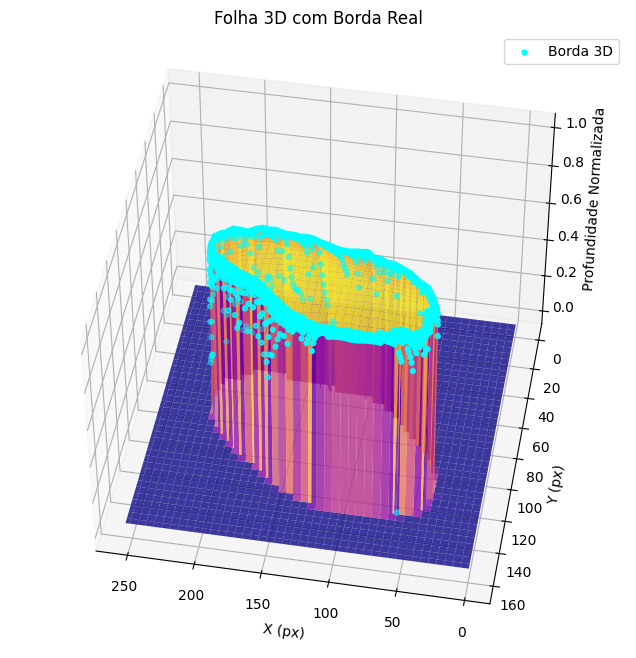

In [38]:
from mpl_toolkits.mplot3d import Axes3D

ys, xs = np.where(dges)
zs = depth_leaf[ys, xs]

h, w = depth_leaf.shape
X, Y = np.meshgrid(np.arange(w), np.arange(h))
Z = depth_leaf

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none', alpha=0.8)
ax.scatter(xs, ys, zs, color='cyan', s=12, label='Borda 3D')
ax.set_title('Folha 3D com Borda Real')
ax.set_xlabel('X (px)')
ax.set_ylabel('Y (px)')
ax.set_zlabel('Profundidade Normalizada')
ax.view_init(elev=45, azim=100)
ax.legend()
plt.show()


Calculamos o esqueleto da borda e extraímos os pontos de maior curvatura como candidatos a vértices da folha.

(A **esqueletonização** transforma uma região binária 2D em um conjunto de linhas 1D que mantém a topologia da forma original. Cada ponto do esqueleto é, por definição, aproximadamente equidistante de duas bordas da forma, o que o torna ideal para representar nervuras, lobos e saliências.)

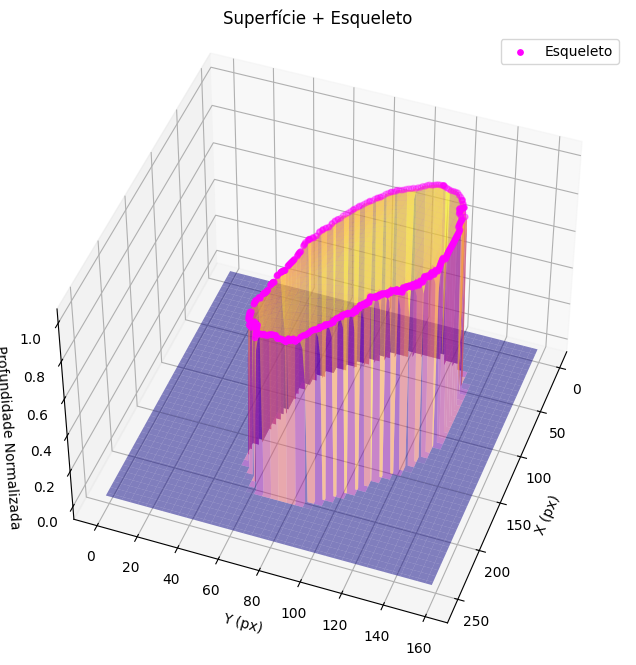

In [39]:
from skimage.morphology import skeletonize

# Geração da máscara binária
binary = ((grad_mag > th) & (rim > 0)).astype(np.uint8)

# Aplicar skeletonize
skeleton = skeletonize(binary)

# Extrair coordenadas do esqueleto
ys_sk, xs_sk = np.where(skeleton)
zs_sk = depth_leaf[ys_sk, xs_sk]

# Plot 3D do esqueleto
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none', alpha=0.5)
ax.scatter(xs_sk, ys_sk, zs_sk, color='magenta', s=15, label='Esqueleto')
ax.set_title('Superfície + Esqueleto')
ax.set_xlabel('X (px)')
ax.set_ylabel('Y (px)')
ax.set_zlabel('Profundidade Normalizada')
ax.view_init(elev=45, azim=20)
ax.legend()
plt.show()

Utilizamos **KMeans** para agrupar os pontos do esqueleto e selecionamos os pontos com maior curvatura em cada cluster.

c:\Users\nbbri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


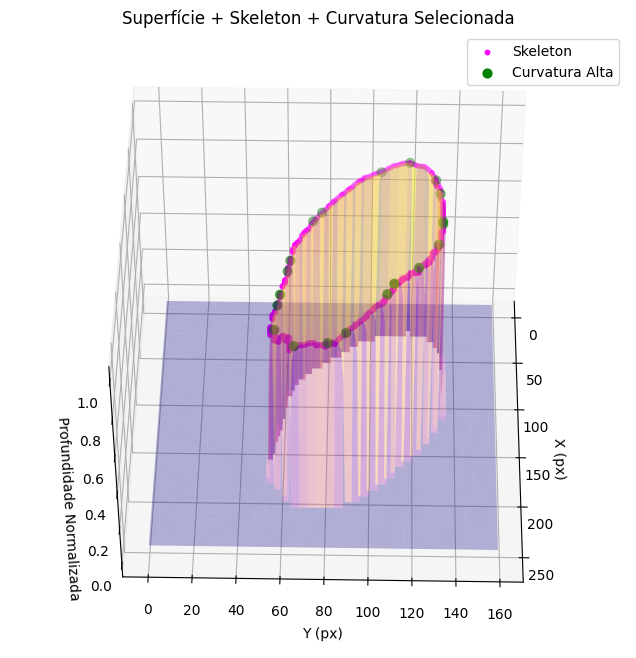

In [40]:
from scipy.ndimage import gaussian_filter1d

# Formar contorno do esqueleto
contour_sk = np.vstack([xs_sk, ys_sk]).T
contour_closed = np.vstack([contour_sk, contour_sk[0]])  # fechar para suavidade

# Função de derivadas suavizadas
def smooth_derivative(signal, sigma=3.0):
    smoothed = gaussian_filter1d(signal, sigma, axis=0)
    grad = np.gradient(smoothed, axis=0)
    return grad

# Derivadas
dx = smooth_derivative(contour_closed[:, 0])
dy = smooth_derivative(contour_closed[:, 1])
d2x = smooth_derivative(dx)
d2y = smooth_derivative(dy)

# Curvatura (absoluta)
curvature = (dx * d2y - dy * d2x) / ((dx**2 + dy**2)**1.5 + 1e-10)
abs_curvature = np.abs(curvature[:-1])  # corresponde à forma de contour_sk

from sklearn.cluster import KMeans

# Número de pontos desejados
num_points = min(20, len(xs_sk))

# KMeans nos pontos XY do esqueleto
kmeans = KMeans(n_clusters=num_points, random_state=42).fit(contour_sk)
labels = kmeans.labels_

# Seleciona o ponto com maior curvatura de cada cluster
final_indices = []
for i in range(num_points):
    cluster_idxs = np.where(labels == i)[0]
    if len(cluster_idxs) == 0:
        continue
    best_idx = cluster_idxs[np.argmax(abs_curvature[cluster_idxs])]
    final_indices.append(best_idx)

# Coordenadas finais
curv_points = contour_sk[final_indices]
z_curv = zs_sk[final_indices]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Superfície
ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none', alpha=0.3)

# Esqueleto
ax.scatter(xs_sk, ys_sk, zs_sk, color='magenta', s=10, label='Skeleton')

# Pontos de curvatura
ax.scatter(curv_points[:, 0], curv_points[:, 1], z_curv,
           color='green', s=40, label='Curvatura Alta')

ax.set_xlabel('X (px)')
ax.set_ylabel('Y (px)')
ax.set_zlabel('Profundidade Normalizada')
ax.set_title('Superfície + Skeleton + Curvatura Selecionada')
ax.view_init(elev=45, azim=1)
ax.legend()
plt.show()



Para conferir se está ok, projetamos os pontos de curvatura extraídos no plano da imagem original.


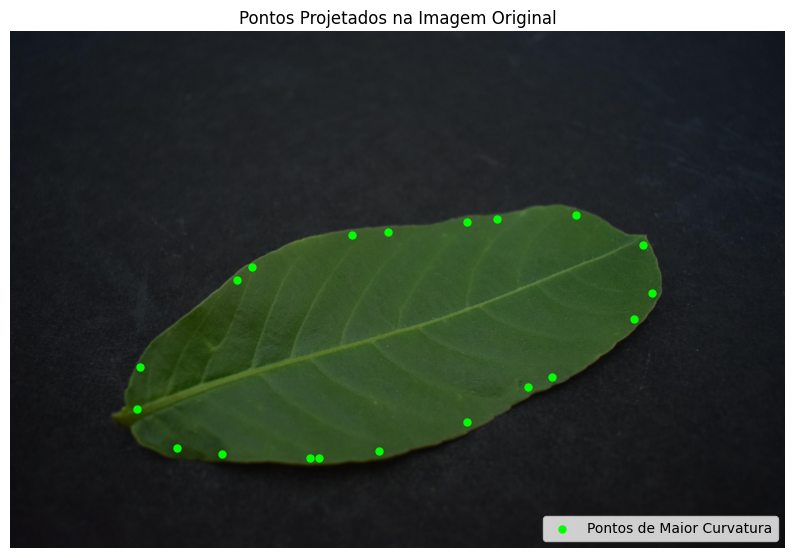

In [41]:
h_orig, w_orig = img.shape[:2]
scale_x = w_orig / w
scale_y = h_orig / h

x_img = curv_points[:, 0] * scale_x
y_img = curv_points[:, 1] * scale_y

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.scatter(x_img, y_img, c='lime', s=25, marker='o', label='Pontos de Maior Curvatura')
plt.axis('off')
plt.title("Pontos Projetados na Imagem Original")
plt.legend(loc='lower right')
plt.show()


## Woodbury

### Estrutura das matrizes

Na construção de splines periódicos, particularmente B-splines de grau $k$, o sistema linear resultante apresenta uma matriz de coeficientes originalmente banda, com largura $2b + 1$ (onde $b = \lfloor k/2 \rfloor$). Contudo, as condições de periodicidade introduzem termos adicionais que conectam as extremidades da matriz, modificando especificamente os cantos de $A$: os blocos superior-direito e inferior-esquerdo, originalmente nulos, passam a conter valores não-nulos, que garantem a continuidade periódica. Essas modificações afetam apenas $r = k - 1$ linhas e colunas, caracterizando uma correção de baixo posto.

Assim, a matriz total pode então ser escrita como: $\tilde{A} = A + U V^T$, onde
- $A \in \mathbb{R}^{n \times n}$: matriz banda de largura $2b + 1$, com $b = \lfloor k/2 \rfloor$;
- $U, V \in \mathbb{R}^{n \times r}$: matrizes que representam a modificação periódica localizada nos cantos, com $r = k - 1$;
- $U V^T$: termo de correção de baixa patente (low-rank), responsável por conectar as extremidades da matriz e garantir a periodicidade.

Resolver diretamente o sistema linear $\tilde{A} x = b$ seria computacionalmente custoso, pois $\tilde{A}$ perde a estrutura esparsa de $A$ e se torna densa. Enquanto sistemas com matrizes banda podem ser resolvidos eficientemente em $O(n w^2)$ (onde $w \approx k$ é a largura de banda), métodos diretos para matrizes densas exigem $O(n^3)$ operações. No caso de B-splines, onde $w \approx k$, a estrutura banda permite eficiência, mas a adição do termo $U V^T$ destrói essa esparsidade.

No entanto, felizmente, a estrutura específica de $\tilde{A}$, isto é, uma matriz banda mais uma correção de baixo posto, permite utilizar a fórmula de Sherman-Morrison para resolver o sistema de forma eficiente, evitando a inversão direta de $\tilde{A}$ e mantendo o custo computacional controlado, próximo de $O(n w^2)$.

### Algoritmo de Woodbury

O algoritmo de Woodbury é uma aplicação prática da identidade de Woodbury, que por sua vez é a forma matricial em blocos da fórmula de Sherman–Morrison. Essa identidade generaliza a inversão de uma matriz que foi perturbada por um termo low-rank.

Ela permite inverter matrizes densas da forma $A + UCV^T$, onde 
- $A \in \mathbb{R}^{n \times n}$ é uma matriz invertível (geralmente esparsa ou com estrutura de banda),

- $U \in \mathbb{R}^{n \times r}$ e $V \in \mathbb{R}^{n \times r}$ são matrizes que definem a correção de baixo posto,

- $C \in \mathbb{R}^{r \times r}$ é uma matriz pequena, também invertível,

- $r \ll n$, ou seja, a correção tem posto muito menor do que a dimensão do sistema.

A fórmula estabelece que $ (A + UCV^T)^{-1} = A^{-1} - A^{-1}U(C^{-1} + V^T A^{-1} U)^{-1} V^T A^{-1} $

A vatange é que se  $A$ é fácil de inverter (por ser esparsa, diagonal ou, no nosso caso, banda), a fórmula evita a inversão direta da matriz densa. Ainda, $UV^T$ tem posto pequeno, e o cálculo de $\left(I + V^T A^{-1} U\right)^{-1}$ envolve apenas uma matriz pequena de dimensão $r \times r$.


A ideia do algoritmo consiste em quatro passos principais: (1) resolver sistemas banda para pré-condicionar a correção, (2) computar uma pequena matriz de ajuste, (3) resolver o sistema banda original e (4) combinar os resultados para obter a solução final. 

<span style="color:; background-color:PaleVioletRed;"> **Passo 1: Resolver sistemas lineares banda $AZ = U$**</span>.
- Para cada coluna $u_i$ da matriz $U \in \mathbb{R}^{n \times r}$, resolve-se o sistema linear banda: $Az_i = u_i $
- Os vetores solução $z_i$ formam as colunas da matriz $Z \in \mathbb{R}^{n \times r}$. Como $A$ é banda, esta operação é computacionalmente eficiente ($\mathcal{O}(n)$ para larguras de banda fixas).

**Passo 2: Calcular a matriz de correção $H = (I + V^TZ)^{-1}$**
<br> Calcula-se:
- O produto $V^TZ \in \mathbb{R}^{r \times r}$ (custo $\mathcal{O}(n r^2)$)
- Soma com a identidade: $I + V^TZ$
- Inversão desta matriz pequena: $H = (I + V^TZ)^{-1}$ (custo $\mathcal{O}(r^3)$)

**Passo 3: Resolver o sistema banda $Ay = b$**
- Resolve-se o sistema linear original (ignorando a correção): $Ay=b$
- Esta solução $y$ seria exata se $UV^T = 0$.

**Passo 4: Calcular a solução final $c = y - ZH(V^Ty)$**
<br> Calcula-se:
- A projeção $V^Ty \in \mathbb{R}^r$ (custo $\mathcal{O}(n r)$)
- Aplica-se a correção: $H(V^Ty)$
- Espalha-se a correção: $ZH(V^Ty) \in \mathbb{R}^n$
- Obtém-se a solução final: $c = y - ZH(V^Ty)$

O vetor $c$ é a solução exata do sistema $(A + UV^T)c = b$.


#### Estabilidade e Complexidade

A complexidade computacional do algoritmo é $O(nw² + r³)$, onde:

- $O(nw^2)$ vem da resolução dos sistemas com a matriz banda $A$. Essa matriz possui largura de banda $w$ (número de diagonais não nulas), o que permite *eliminação gaussiana adaptada**. Cada operação elementar nessa eliminação envolve $O(w^2)$ operações (pois lida apenas com blocos pequenos), repetidas $n$ vezes (número de equações do sistema), mantendo-se $w$ fixo. Como $w \ll n$, o custo é linear em $n$.

- $O(r^3)$ corresponde à inversão da matriz densa $r \times r$, $(I + V^\top A^{-1} U)$, onde $r = \text{rank}(UV^\top) = k - 1$. Como essa matriz é densa, mas de baixa dimensão, e $k$ (grau do B-spline) é pequeno na prática (tipicamente $k = 3$ ou $5$ para splines cúbicos ou quinticos), esse custo é computacionalmente desprezível em relação ao termo dominante.

Além da eficiência, o método é numericamente estável: a inversão de A (bem-condicionada por ser banda) domina o processo, enquanto a correção de posto baixo $UVᵀ$ introduz mínima perturbação, preservando a precisão.

#### * Eliminação Gaussiana Adaptada para Matrizes Banda

Em um sistema linear geral $Ax = b$, onde $A \in \mathbb{R}^{n \times n}$, a eliminação gaussiana clássica requer $O(n^3)$ operações para resolver o sistema — isso ocorre porque cada etapa pode envolver combinações de linhas completas, afetando a matriz inteira.

Porém, quando $A$ é uma matriz banda, com largura de banda total $w = l + u + 1$ (sendo $l$ o número de subdiagonais e $u$ o número de superdiagonais), a situação muda drasticamente. A matriz banda tem uma forma onde a maior parte da matriz é composta de zeros, exceto por uma faixa diagonal de largura $w$.

$A = \begin{pmatrix}
a_{11} & a_{12} & \cdots & a_{1,u+1} & 0 & \cdots & 0 \\
a_{21} & a_{22} & \cdots & a_{2,u+2} & \ddots & \ddots & \vdots \\
\vdots & \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
0 & \cdots & a_{n,n-l} & \cdots & \cdots & \cdots & a_{nn}
\end{pmatrix}$

Durante a eliminação gaussiana, cada pivô $a_{ii}$ afeta apenas as próximas $l$ linhas e $u$ colunas. Como consequência, cada etapa da eliminação envolve apenas $O(w^2)$ operações (em vez de $O(n^2)$), e como há $n$ pivôs, o custo total é $O(nw^2)$ 
